# OLYMPIC GAMES DATA EXPLORATION

In [2]:
from mysecrets import pw
import functions

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Let's directly connect to our MySQL Database that contains the already processed and usable data.
connection = functions.create_db_connection("localhost", "root", pw, "ProcessedSportsStats")

MySQL Database connection successful


In [4]:
# Set style
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (9, 5)

### EXPLORATION ABOUT AGE OF MEDALISTS

In [5]:
query = """SELECT *
    FROM Events;"""
events_df = pd.read_sql(query, connection, index_col=['EventId'])

events_df.head()


/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_24559/1777497206.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  events_df = pd.read_sql(query, connection, index_col=['EventId'])


,AthleteId,Age,Team,NOC,Games,Category,Medal
EventId,,,,,,,
1,1,24.0,China,CHN,1992 Summer,Basketball Men's Basketball,None
2,2,23.0,China,CHN,2012 Summer,Judo Men's Extra-Lightweight,None
3,3,24.0,Denmark,DEN,1920 Summer,Football Men's Football,None
4,4,34.0,Denmark/Sweden,DEN,1900 Summer,Tug-Of-War Men's Tug-Of-War,Gold
5,5,21.0,Netherlands,NED,1988 Winter,Speed Skating Women's 500 metres,None


In [6]:
medalists_df = events_df[~events_df['Medal'].isnull()]
medalists_df

,AthleteId,Age,Team,NOC,Games,Category,Medal
EventId,,,,,,,
4,4,34.0,Denmark/Sweden,DEN,1900 Summer,Tug-Of-War Men's Tug-Of-War,Gold
38,15,30.0,Finland,FIN,1920 Summer,Swimming Men's 200 metres Breaststroke,Bronze
39,15,30.0,Finland,FIN,1920 Summer,Swimming Men's 400 metres Breaststroke,Bronze
41,16,28.0,Finland,FIN,2014 Winter,Ice Hockey Men's Ice Hockey,Bronze
42,17,28.0,Finland,FIN,1948 Summer,Gymnastics Men's Individual All-Around,Bronze
...,...,...,...,...,...,...,...
271079,135553,25.0,Soviet Union,URS,1956 Summer,Athletics Women's Shot Put,Silver
271081,135553,33.0,Soviet Union,URS,1964 Summer,Athletics Women's Shot Put,Bronze
271083,135554,28.0,Poland,POL,1980 Summer,"Fencing Men's Foil, Team",Bronze


In [7]:
medalists_df['Age'].max()

73.0

In [8]:
medalists_df['Age'].min()

10.0

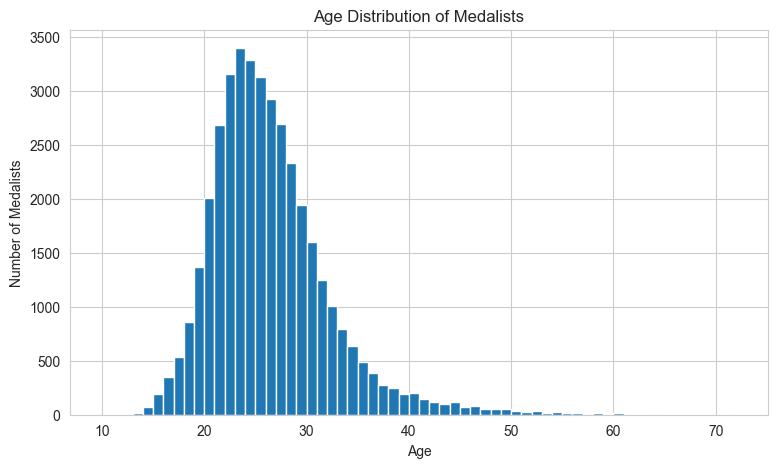

In [9]:
# Find how many medalists we encounter for each AGE group and visualise it
plt.title('Age Distribution of Medalists')
plt.xlabel('Age')
plt.ylabel('Number of Medalists')

plt.hist(medalists_df.Age, bins=np.arange(10,73,1));

It makes sense most medalist's ages range in between 20 and 30. In particular, the descriptive stats are:

In [10]:
medalists_df['Age'].describe()

count    39051.000000
mean        25.925175
std          5.914026
min         10.000000
25%         22.000000
50%         25.000000
75%         29.000000
max         73.000000
Name: Age, dtype: float64

I am now interested in knowing the mean of medalists in different sports. That is, if the best age for sports performance varies depending on the sport.

In [11]:
query = """SELECT *
    FROM Categories;"""
categories_df = pd.read_sql(query, connection)

categories_df.head()

/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_24559/2678237404.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  categories_df = pd.read_sql(query, connection)


,Category,Sport
0,Aeronautics Mixed Aeronautics,Aeronautics
1,Alpine Skiing Men's Combined,Alpine Skiing
2,Alpine Skiing Men's Downhill,Alpine Skiing
3,Alpine Skiing Men's Giant Slalom,Alpine Skiing
4,Alpine Skiing Men's Slalom,Alpine Skiing


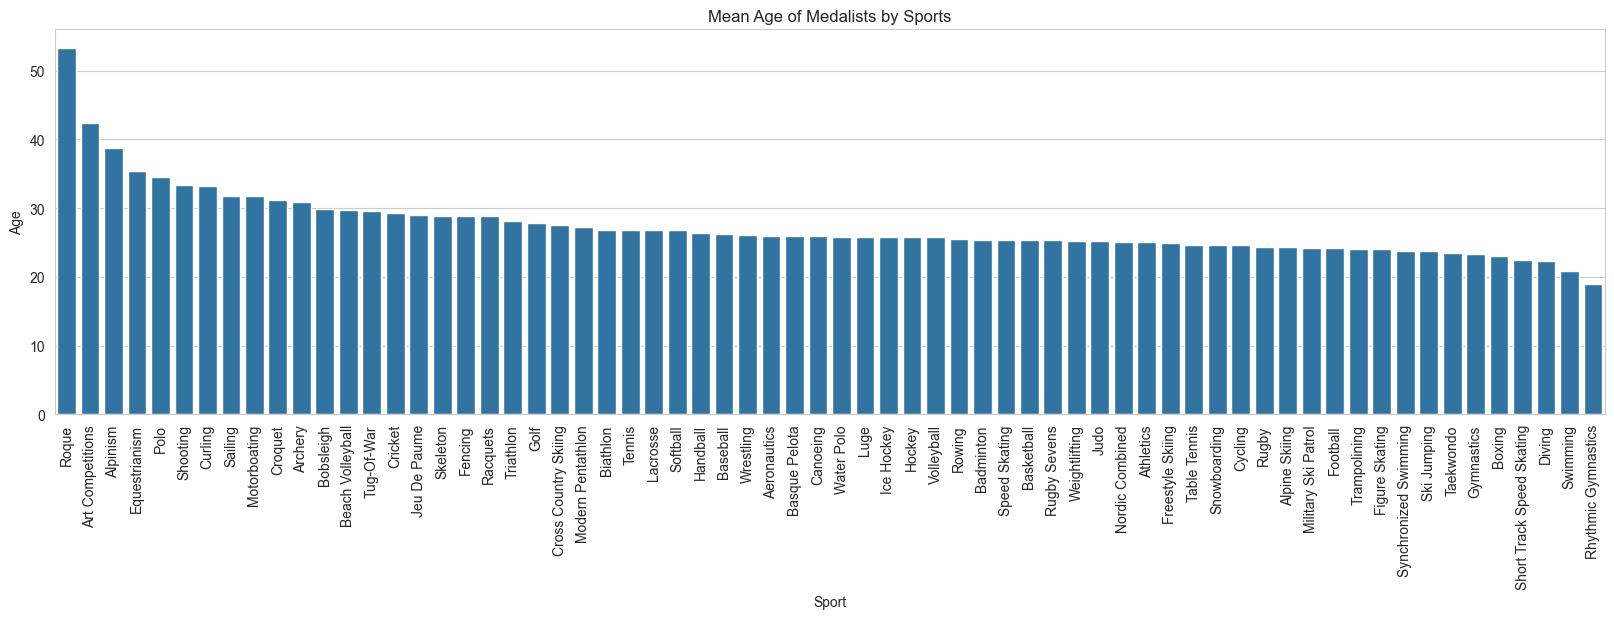

In [12]:
age_grouped_sports_df = medalists_df.merge(categories_df, on='Category', how='left').groupby("Sport")["Age"].mean().sort_values(ascending=False)
matplotlib.rcParams['figure.figsize'] = (20, 5)
plt.xticks(rotation=90)
plt.title('Mean Age of Medalists by Sports')
sns.barplot(x=age_grouped_sports_df.index, y=age_grouped_sports_df);


### EXPLORATION ABOUT SPORT-REGION RELATION

In [13]:
query = """SELECT *
    FROM NOC
    WHERE Region IS NOT NULL;"""
noc_df = pd.read_sql(query, connection)

noc_df

/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_24559/824951885.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  noc_df = pd.read_sql(query, connection)


,NOC,Region,Notes
0,AFG,Afghanistan,None
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,None
3,ALG,Algeria,None
4,AND,Andorra,None
...,...,...,...
219,YEM,Yemen,None
220,YMD,Yemen,South Yemen
221,YUG,Serbia,Yugoslavia
222,ZAM,Zambia,None


In [14]:
# merge as to have region and sport in the row of each event.
sport_region_df = medalists_df.merge(categories_df, on='Category', how='left').merge(noc_df[['NOC','Region']], on='NOC')

# Now, let's count a Gold medal as 3 points, Silver as 2 and Bronze as 1 (as to add value to the medals)
sport_region_df.loc[sport_region_df["Medal"] == "Gold", "Medal"] = 3
sport_region_df.loc[sport_region_df["Medal"] == "Silver", "Medal"] = 2
sport_region_df.loc[sport_region_df["Medal"] == "Bronze", "Medal"] = 1

# Now, group by Sport and country and sum the points they have
sport_region_df = sport_region_df.groupby(["Region", "Sport"]).agg(Points = ('Medal', 'sum')).sort_values(by=['Points'], ascending=False)

# And now we are just interested to show per region, the sport that has max points
idx = sport_region_df.groupby("Region")['Points'].transform(max) == sport_region_df['Points']
sport_region_df = sport_region_df[idx].reset_index()	
sport_region_df.head(50)

/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_24559/782644863.py:13: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = sport_region_df.groupby("Region")['Points'].transform(max) == sport_region_df['Points']


,Region,Sport,Points
0,USA,Swimming,2630
1,Germany,Rowing,1107
2,Russia,Gymnastics,893
3,Canada,Ice Hockey,881
4,Australia,Swimming,823
5,Italy,Fencing,797
6,France,Fencing,660
7,UK,Athletics,627
8,Netherlands,Hockey,502
9,Hungary,Fencing,502


In [15]:
# And now a bit of exploration over this:
sport_region_df[(sport_region_df['Sport'] == "Ice Hockey") | (sport_region_df['Sport'] == "Cross Country Skiing") | (sport_region_df['Sport'] == "Alpine Skiing")]

,Region,Sport,Points
3,Canada,Ice Hockey,881
11,Sweden,Ice Hockey,381
13,Norway,Cross Country Skiing,345
17,Czech Republic,Ice Hockey,300
24,Austria,Alpine Skiing,221
74,Liechtenstein,Alpine Skiing,15


It makes sense all these countries whose best sport is something ice-skiing related are cold countries, and weather and culture helps.

In [16]:
sport_region_df[sport_region_df['Sport'] == 'Athletics']

,Region,Sport,Points
7,UK,Athletics,627
15,Finland,Athletics,308
16,Jamaica,Athletics,307
25,Kenya,Athletics,205
30,Poland,Athletics,154
37,Ethiopia,Athletics,106
41,Bahamas,Athletics,71
43,South Africa,Athletics,64
46,Trinidad,Athletics,54
55,Morocco,Athletics,36


In [17]:
sport_region_df[sport_region_df['Sport'] =='Swimming']

,Region,Sport,Points
0,USA,Swimming,2630
4,Australia,Swimming,823
86,Costa Rica,Swimming,7
102,Suriname,Swimming,4
